# 트렌스포머2GPT1

넣어줄 데이터셋의 처리 방식이 변경되었습니다

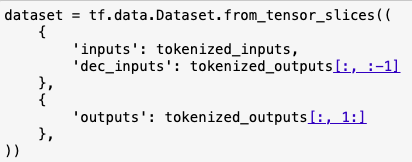

GPT 모델에서는 입력 데이터가 Transformer와 다르게, 문맥과 질문을 구분자 토큰 $를 사용하여 결합하는 방식으로 되어 있습니다. 하지만 Context가 없기 때문에, 질문과 답변 데이터만을 사용했습니다.

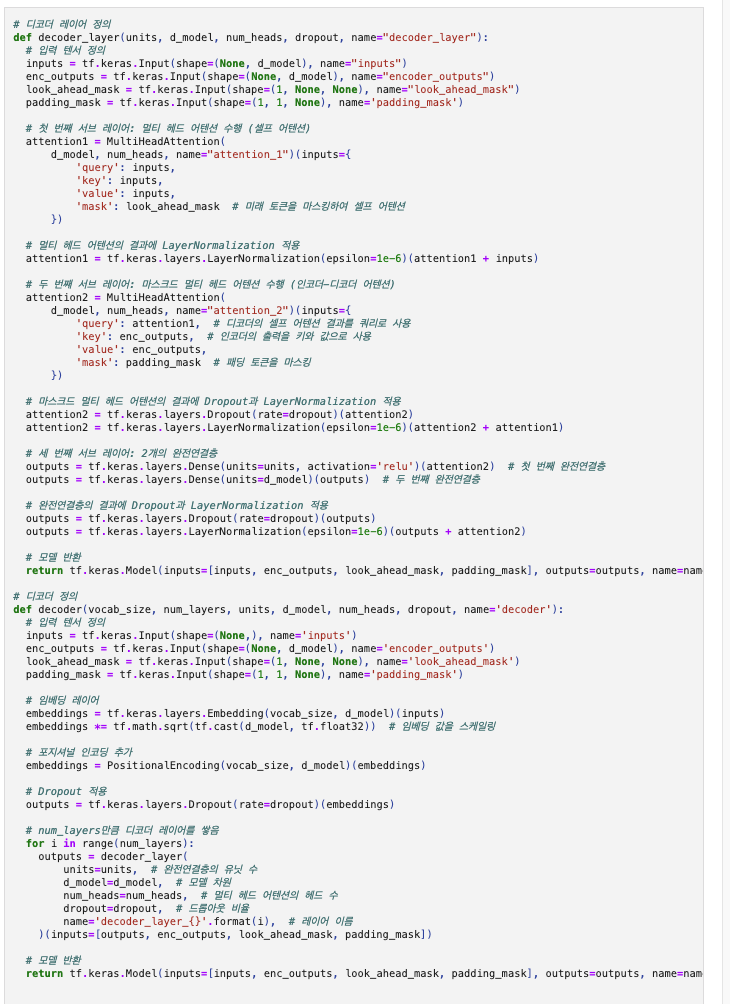

기존의 코드에서 인코더와 트렌스포머 모델을 제거했고 디코더부분에 필요없는 부분을 제고하고 간소화 했다.
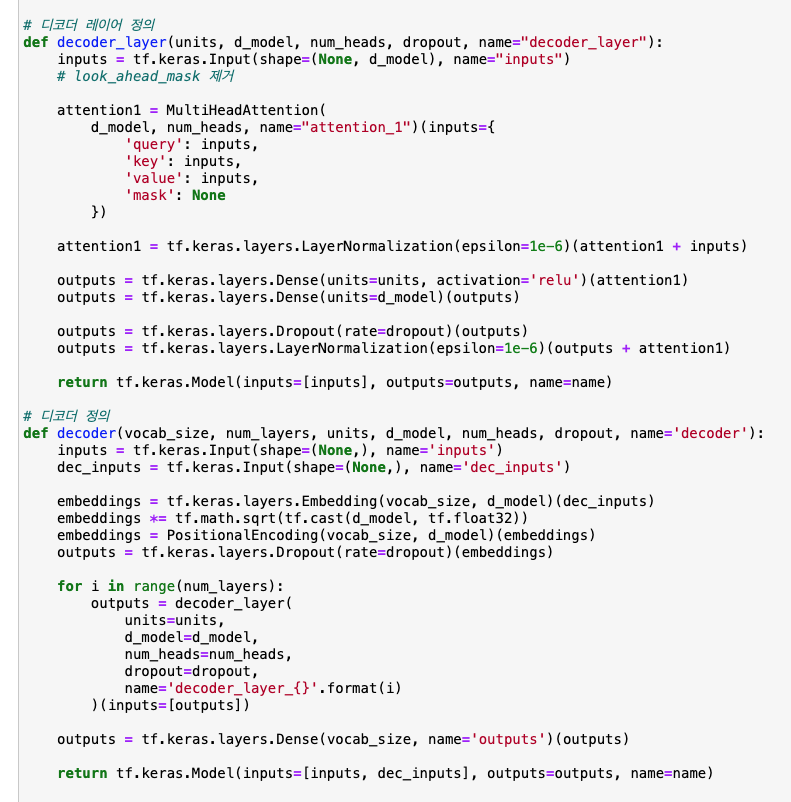

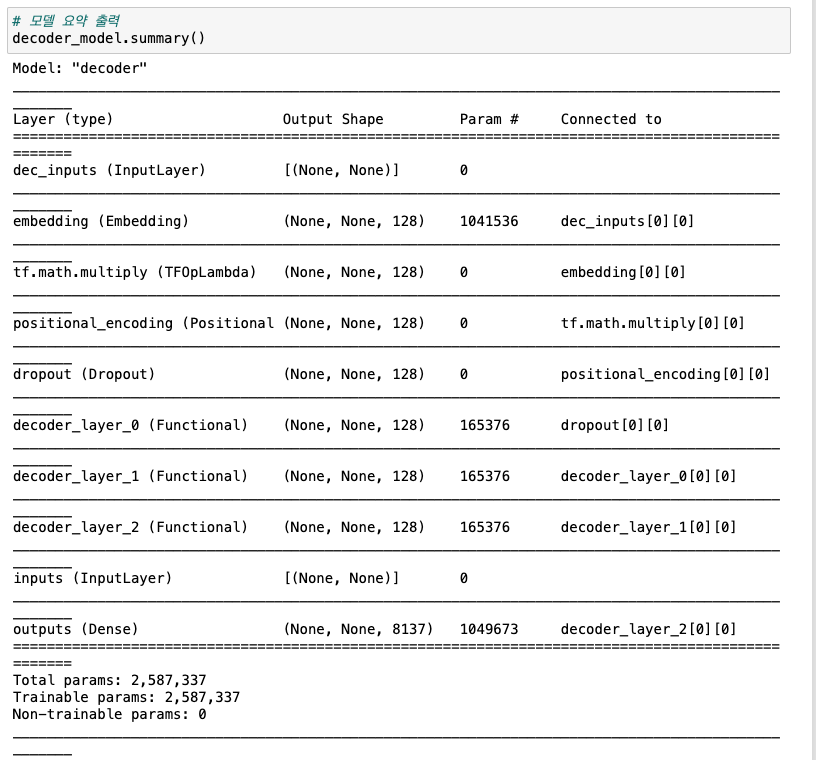

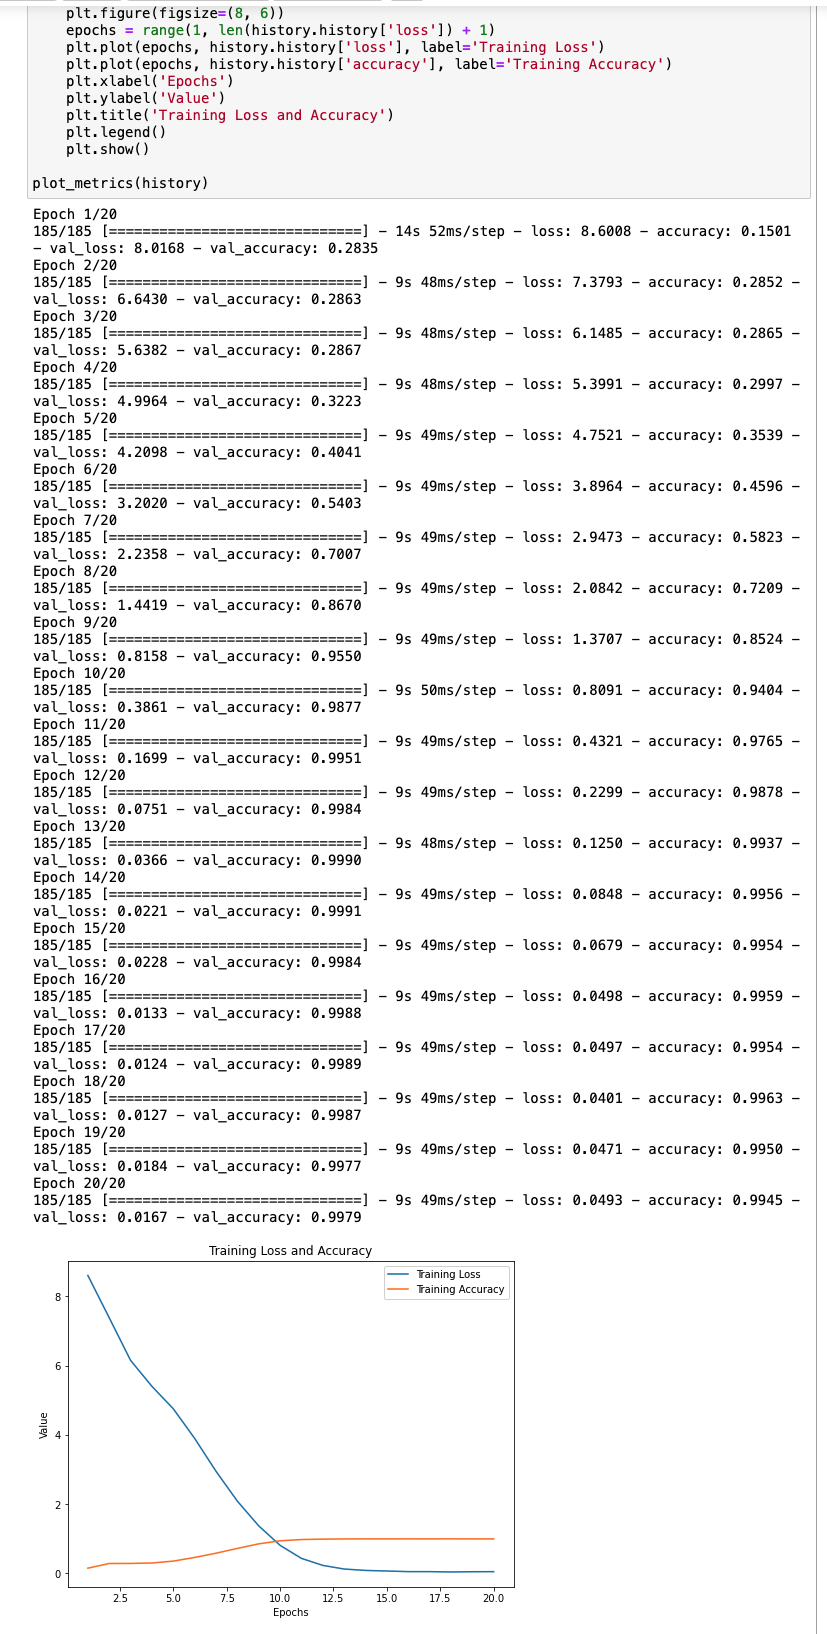

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
path_to_csv = '/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(path_to_csv)

In [3]:
max_samples = 50000  # 최대 샘플 수를 50,000으로 설정

# 전처리 함수 정의
def preprocess_sentence(sentence):
    # 문장을 소문자로 변환하고 양쪽 끝의 공백을 제거합니다.
    sentence = sentence.lower().strip()
    
    # 구두점(?.!,) 앞뒤에 공백을 추가합니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 연속된 공백을 하나의 공백으로 대체합니다.
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 한글, 영어, 구두점(?.!,)을 제외한 모든 문자를 공백으로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z?.!,]+", " ", sentence)
    
    # 양쪽 끝의 공백을 제거합니다.
    sentence = sentence.strip()
    
    return sentence

def load_conversations():
    # 질문과 답변 데이터 추출 및 전처리
    inputs = []
    outputs = []
    for index, row in data.iterrows():
        inputs.append(preprocess_sentence(row['Q']))
        outputs.append(preprocess_sentence(row['A']))
        
        if len(inputs) >= max_samples:
            break
    return inputs, outputs

questions, answers = load_conversations()

print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 어휘 집합 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, 
    target_vocab_size=2**13
)
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

MAX_LENGTH = 40
print('START_TOKEN의 번호 :', [tokenizer.vocab_size])
print('END_TOKEN의 번호 :', [tokenizer.vocab_size + 1])



def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

tokenized_inputs, tokenized_outputs = tokenize_and_filter(questions, answers)

BUFFER_SIZE = 20000
BATCH_SIZE = 64

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': tokenized_inputs,
        'dec_inputs': tokenized_outputs[:, :-1]
    },
    {
        'outputs': tokenized_outputs[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 포지셔널 인코딩 레이어

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)  # 포지셔널 인코딩을 생성

    def get_angles(self, position, i, d_model):
        # 각도를 계산하는 함수
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  # 위치 인덱스
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],  # 모델 차원 인덱스
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]  # 배치 차원을 추가
        return tf.cast(pos_encoding, tf.float32)  # float32로 캐스팅

    def call(self, inputs):
        # 입력에 포지셔널 인코딩을 더해 반환
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


# 스케일된 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    dk = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.wq(query)
        key = self.wk(key)
        value = self.wv(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output

    
    
# 마스킹 함수

def create_padding_mask(x):
  # 패딩 마스크 생성: 입력 x에서 0인 위치를 찾아 마스크를 생성
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)의 형태로 반환
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  # 시퀀스 길이를 가져옴
  seq_len = tf.shape(x)[1]
  # Look-ahead 마스크 생성: 하삼각 행렬을 만들어 미래의 토큰을 가림
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  # 패딩 마스크 생성
  padding_mask = create_padding_mask(x)
  # look_ahead_mask와 padding_mask 중 큰 값을 선택하여 반환
  return tf.maximum(look_ahead_mask, padding_mask)
    
    
look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    
    
    
# 디코더 레이어 정의
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    # look_ahead_mask 제거

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': None
        })

    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention1)

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

# 디코더 정의
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(dec_inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i)
        )(inputs=[outputs])

    outputs = tf.keras.layers.Dense(vocab_size, name='outputs')(outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)



# 하이퍼파라미터
NUM_LAYERS = 3 # 인코더와 디코더의 층의 개수
D_MODEL = 128 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 384 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

# decoder 모델 생성
decoder_model = decoder(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)



class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy(real, pred):
    real = tf.cast(real, dtype=tf.int64)  # 추가된 부분
    pred = tf.argmax(pred, axis=2, output_type=tf.int64)  # 추가된 부분
    accuracies = tf.equal(real, pred)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)



살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
START_TOKEN의 번호 : [8135]
END_TOKEN의 번호 : [8136]


In [4]:
# 모델 요약 출력
decoder_model.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    1041536     dec_inputs[0][0]                 
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, None, 128)    0           embedding[0][0]                  
__________________________________________________________________________________________________
positional_encoding (Positional (None, None, 128)    0           tf.math.multiply[0][0]           
____________________________________________________________________________________________

Epoch 1/20
185/185 [==============================] - 14s 52ms/step - loss: 8.6008 - accuracy: 0.1501 - val_loss: 8.0168 - val_accuracy: 0.2835
Epoch 2/20
185/185 [==============================] - 9s 48ms/step - loss: 7.3793 - accuracy: 0.2852 - val_loss: 6.6430 - val_accuracy: 0.2863
Epoch 3/20
185/185 [==============================] - 9s 48ms/step - loss: 6.1485 - accuracy: 0.2865 - val_loss: 5.6382 - val_accuracy: 0.2867
Epoch 4/20
185/185 [==============================] - 9s 48ms/step - loss: 5.3991 - accuracy: 0.2997 - val_loss: 4.9964 - val_accuracy: 0.3223
Epoch 5/20
185/185 [==============================] - 9s 49ms/step - loss: 4.7521 - accuracy: 0.3539 - val_loss: 4.2098 - val_accuracy: 0.4041
Epoch 6/20
185/185 [==============================] - 9s 49ms/step - loss: 3.8964 - accuracy: 0.4596 - val_loss: 3.2020 - val_accuracy: 0.5403
Epoch 7/20
185/185 [==============================] - 9s 49ms/step - loss: 2.9473 - accuracy: 0.5823 - val_loss: 2.2358 - val_accuracy: 0.700

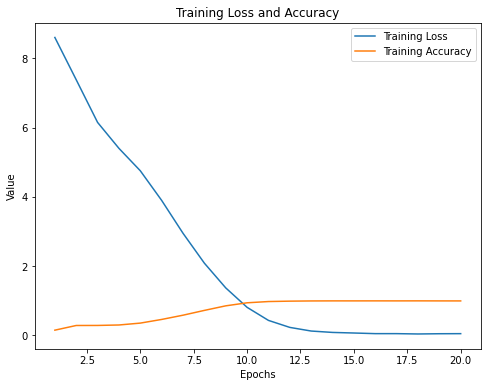

In [5]:
decoder_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

history = decoder_model.fit(
    dataset,
    epochs=20,
    verbose=1,
    validation_data=dataset
)
def plot_metrics(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title('Training Loss and Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)

In [6]:
# 평가 함수 정의
def evaluate(model, dataset):
    total_loss = 0
    num_batches = 0
    for inputs, targets in dataset:
        predictions = model([inputs['inputs'], inputs['dec_inputs']], training=False)
        loss = loss_function(targets['outputs'], predictions)
        total_loss += loss.numpy()
        num_batches += 1
    return total_loss / num_batches

# 패딩 마스크 생성 함수
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# look-ahead 마스크 생성 함수
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask[tf.newaxis, tf.newaxis, :, :]

def decoder_inference(sentence):
    # 입력된 문장을 전처리합니다.
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도로 저장. 예: [START_TOKEN]
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = decoder_model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]  # 마지막 토큰에 대한 예측만 가져옴

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들을 지속적으로 output_sequence에 추가합니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    # 최종 예측된 시퀀스를 반환합니다. (배치 차원을 제거)
    return tf.squeeze(output_sequence, axis=0)

def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])  # 어휘 집합 크기 이하의 정수들만 변환

    # 입력 문장과 출력 문장을 출력합니다.
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence  # 예측된 문장을 반환

In [7]:
sentence_generation('오늘 날씨가 어떨까?')

입력 : 오늘 날씨가 어떨까?
출력 : 으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요


'으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요으니까요'